In [1]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os

## Joining DEM tiles

### Saving mosaic to a disk

## Dividing DEM tiles

In [34]:
from shapely import geometry
from rasterio.mask import mask

# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim
def splitImageIntoCells(img, filename, squareDim):
    numberOfCellsWide = img.shape[1] // squareDim
    numberOfCellsHigh = img.shape[0] // squareDim
    x, y = 0, 0
    count = 0
    for hc in range(numberOfCellsHigh):
        y = hc * squareDim
        for wc in range(numberOfCellsWide):
            x = wc * squareDim
            geom = getTileGeom(img.transform, x, y, squareDim)
            getCellFromGeom(img, geom, filename, count)
            count = count + 1

# Generate a bounding box from the pixel-wise coordinates using the original datasets transform property
def getTileGeom(transform, x, y, squareDim):
    corner1 = (x, y) * transform
    corner2 = (x + squareDim, y + squareDim) * transform
    return geometry.box(corner1[0], corner1[1],
                        corner2[0], corner2[1])

# Crop the dataset using the generated box and write it out as a GeoTIFF
def getCellFromGeom(img, geom, filename, count):
    crop, cropTransform = mask(img, [geom], crop=True)
    writeImageAsGeoTIFF(crop,
                        cropTransform,
                        img.meta,
                        img.crs,
                        filename+"_"+str(count))

# Write the passed in dataset as a GeoTIFF
def writeImageAsGeoTIFF(img, transform, metadata, crs, filename):
    metadata.update({"driver":"GTiff",
                     "height":img.shape[1],
                     "width":img.shape[2],
                     "transform": transform,
                     "crs": crs})
    with rasterio.open(filename+".tif", "w", **metadata) as dest:
        dest.write(img)

In [13]:
dirpath = r'SwedenData/Raw_data/Dem_tiles/3DAlos_big/'
search_criteria = "*/*DSM.tif"
q = os.path.join(dirpath, search_criteria)
dem_tiles_paths  = glob.glob(q) 

In [28]:
idx = 66
dem_big = rasterio.open(dem_tiles_paths[idx]).read()[0]
print(dem_big.shape)

(3600, 1800)


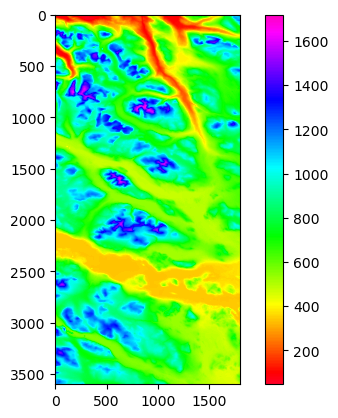

In [29]:
plt.imshow(dem_big, cmap='gist_rainbow')
plt.colorbar()


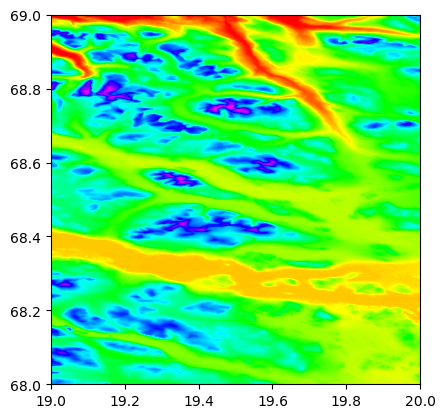

<Axes: >

In [31]:
dem_tiles_paths
show(rasterio.open(dem_tiles_paths[idx]),cmap='gist_rainbow')

In [41]:
print(len(dem_tiles_paths))

144


In [37]:
print('Starting to create dem tiles of size 100')

Starting to create dem tiles of size 100


In [38]:
# for multiple dem tiles
import pathlib

for dem_path in dem_tiles_paths:
    file_name = dem_path.split('/')[-1].split('.')[0]
    
    #create directory
    directory = file_name
    parent_dir = "/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/"
    new_folder_path = os.path.join(parent_dir, directory)
    pathlib.Path(new_folder_path).mkdir(exist_ok=True)
    print("Directory '%s' created" %directory)
    
    #divide and save in directory
    one_dem = rasterio.open(dem_path)
    splitImageIntoCells(one_dem, new_folder_path+'/'+file_name, 100)


Directory 'ALPSMLC30_N056E012_DSM' created


/tmp/ipykernel_2824020/2651692014.py:20: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  corner1 = (x, y) * transform
/tmp/ipykernel_2824020/2651692014.py:21: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  corner2 = (x + squareDim, y + squareDim) * transform


# Merging Sat Tiles

In [12]:
# File and folder paths
dirpath = r'SwedenData/Raw_data/Sat_labels/'
out_fp = r'SwedenData/Raw_data/MERGED_ALL_SAT/MERGED_ALL_SAT.tif'

# Make a search criteria to select the DEM files
search_criteria = "*.tif"
q = os.path.join(dirpath, search_criteria)

print(q)

SwedenData/Raw_data/Sat_labels/*.tif


In [13]:
dem_fps = glob.glob(q)
dem_fps

['SwedenData/Raw_data/Sat_labels/Z_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/Y_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/BD_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/AB_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/AC_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/C_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/D_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/E_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/F_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/G_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/H_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/I_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenData/Raw_data/Sat_labels/K_lan_nmd2018bas_ogeneraliserad_v1_1.tif',
 'SwedenD

In [14]:
src_files_to_mosaic = []

for fp in dem_fps:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='SwedenData/Raw_data/Sat_labels/Z_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/Y_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/BD_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/AB_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/AC_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/C_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/D_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/E_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>,
 <open DatasetReader name='SwedenData/Raw_data/Sat_labels/F_lan_nmd2018bas_ogeneraliserad_v1_1.tif' mode='r'>

In [15]:
mosaic, out_trans = merge(src_files_to_mosaic)

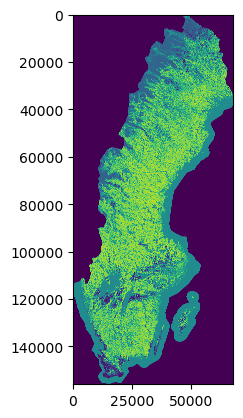

<Axes: >

In [19]:
plt.figure(figsize=(5,10))
show(mosaic)#, cmap='terrain')

In [16]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans,
                  #"crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                  }
                 ) 

In [17]:
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 67598,
 'height': 155979,
 'count': 1,
 'crs': CRS.from_epsg(3006),
 'transform': Affine(10.0, 0.0, 245110.0,
        0.0, -10.0, 7671060.0)}

In [18]:
with rasterio.open(out_fp, "w", **out_meta) as dest:
     dest.write(mosaic)

## Other reprojection method?

In [20]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'
sat_path  = '/home/azamat.kaibaldiyev/SwedenData/Raw_data/MERGED_ALL_SAT/MERGED_ALL_SAT.tif'
new_repr_path = '/home/azamat.kaibaldiyev/SwedenData/Raw_data/Reprojected_MERGED_ALL_SAT/Reprojected_MERGED_ALL_SAT.tif'
with rasterio.open(sat_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(new_repr_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

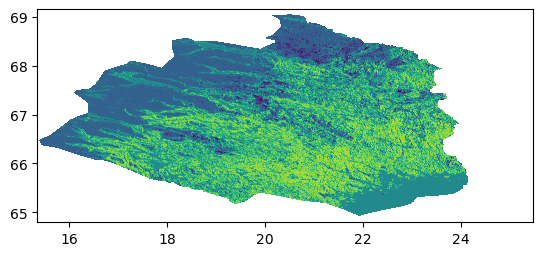

<Axes: >

In [34]:
#new_repr_path = '/home/azamat.kaibaldiyev/SwedenData/Raw_data/Reprojected_MERGED_ALL_SAT/Reprojected_MERGED_ALL_SAT.tif'
#show(rasterio.open(new_repr_path))

In [24]:
new_repr_path = '/home/azamat.kaibaldiyev/SwedenData/Raw_data/Reprojected_MERGED_ALL_SAT/Reprojected_MERGED_ALL_SAT.tif'
reproj_sat = rasterio.open(new_repr_path)
reproj_sat.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 149999,
 'height': 125993,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00011254540954032165, 0.0, 8.608106807945488,
        0.0, -0.00011254540954032165, 69.14974198360395)}

# Finding corresponding sat to dem tiles and saving it

In [ ]:
new_repr_path = '/home/azamat.kaibaldiyev/SwedenData/Raw_data/Reprojected_MERGED_ALL_SAT/Reprojected_MERGED_ALL_SAT.tif'
reproj_sat = rasterio.open(new_repr_path)
reproj_sat.meta

In [22]:
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.io import MemoryFile
from rasterio.merge import merge

def create_dataset(data, crs, transform):
    # Receives a 2D array, a transform and a crs to create a rasterio dataset
    memfile = MemoryFile()
    dataset = memfile.open(driver='GTiff', height=data.shape[0], width=data.shape[1], count=1, crs=crs, 
                           transform=transform, dtype=data.dtype)
    dataset.write(data, 1)
        
    return dataset

In [39]:
dem_folders_paths = glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/*')
dem_folders_paths

['/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N056E012_DSM']

In [28]:
from pathlib import Path
import pathlib
import numpy as np

dem_folders_paths = glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/*')

for folder_dir in dem_folders_paths:
    
    # iterate over files in that directory
    images = Path(folder_dir).glob('*.tif')
    new_sat_folder_path = '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/sat/' + folder_dir.split('/')[-1]
    pathlib.Path(new_sat_folder_path).mkdir(exist_ok=True)
    
    for image_path in images:
        try:
            end_name = str(image_path).split('/')[-1].split('.')[0]
            filename = new_sat_folder_path+'/' + end_name
            temp_dem_path = image_path
            temp_dem = rasterio.open(temp_dem_path)
            extents, _ = next(shapes(np.zeros_like(temp_dem.read()), transform=temp_dem.profile['transform']))
            cropped, crop_transf = mask(reproj_sat, [extents], crop=True)
            cropped_ds = create_dataset(cropped[0], reproj_sat.crs, crop_transf)
            writeImageAsGeoTIFF(cropped,
                                crop_transf,
                                cropped_ds.meta,
                                cropped_ds.crs,
                                filename)
            print('Sat image '+filename+' is saved')
        except:
            print('----Outside of zone: '+ end_name)
        
    break


Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_0 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_1 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_2 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_3 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_4 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_5 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_6 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_64 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_65 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_66 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_67 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_68 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_69 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_70 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/AL

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_131 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_132 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_133 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_134 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_135 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_136 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_137 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_196 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_197 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_198 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_199 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_200 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_201 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_202 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_267 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_268 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_269 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_270 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_271 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_272 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_273 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_339 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_340 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_341 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_342 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_343 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_344 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_345 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_409 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_410 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_411 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_412 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_413 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_414 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_415 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_477 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_478 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_479 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_480 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_481 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_482 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_483 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_540 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_541 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_542 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_543 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_544 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_545 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_546 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_602 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_603 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_604 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_605 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_606 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_607 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_608 is saved
Sat image /home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_

In [ ]:
#'/home/azamat.kaibaldiyev/SwedenData/100tiles_new1/dem/ALPSMLC30_N068E023_DSM'

In [31]:
sat_images = glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/*')

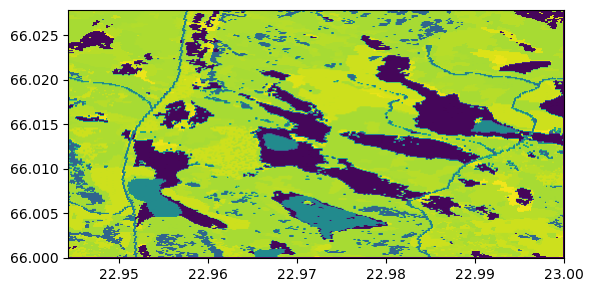

[[[  0   0   0 ...   0   0   0]
  [  0 113 113 ... 111 111   0]
  [  0 113 113 ... 111 111   0]
  ...
  [  0 114 118 ... 118 118   0]
  [  0 118 111 ... 125 125   0]
  [  0   0   0 ...   0   0   0]]]


In [33]:
i = -1
sat_test = rasterio.open(sat_images[i])
show(sat_test)
print(sat_test.read())

# For thesis

In [2]:
import matplotlib.pyplot as plt
import rasterio
out_fp = 'SwedenData/Raw_data/MERGED_ALL_SAT/MERGED_ALL_SAT.tif'

In [3]:
dem_whole = rasterio.open(out_fp)

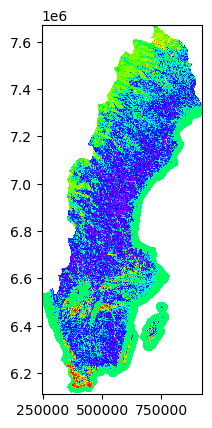

<Axes: >

In [4]:
#plt.figure(figsize=(5,10))
show(dem_whole,cmap='gist_rainbow')


In [ ]:
plt.figure(figsize=(5,10))
show(dem_whole,cmap='gist_rainbow')

In [11]:
dem_whole.read()[0].shape

(155979, 67598)

In [3]:
dem_val = dem_whole.read()

In [ ]:
import cv2
import numpy as np

res = cv2.resize(dem_val, dsize=(1559, 675), interpolation=cv2.INTER_CUBIC)
res

In [4]:
import numpy as np
masked_array = np.ma.masked_where(dem_val == 0, dem_val)


In [20]:
masked_array.shape

(1, 155979, 67598)

In [5]:
import matplotlib.pyplot as plt
import numpy

w = 1559
h = 675

fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
plt.imshow(masked_array[0], cmap='gist_rainbow')
plt.colorbar()
plt.savefig('Images_thesis/aSweden_dem.png',format="png",  bbox_inches='tight',dpi=1)#dpi=resolution_value,

RuntimeError: In set_size: Could not set the fontsize (invalid ppem value; error code 0x97)

Error in callback <function _draw_all_if_interactive at 0x7ff5bafa6680> (for post_execute):


ValueError: Image size of 155900x67500 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 155900x67500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 155900x67500 with 2 Axes>

In [31]:
#cmap = matplotlib.cm.gist rainbow  # Can be any colormap that you want after the cm
#cmap.set_bad(color='white')
plt.figure(figsize=(5,10))
plt.imshow(masked_array[0], cmap='gist_rainbow')
plt.colorbar()
#resolution_value = 1200
#plt.savefig('Images_thesis/aSweden_dem.png',format="png",  bbox_inches='tight',dpi=0.00001)#dpi=resolution_value,

Error in callback <function flush_figures at 0x7f2d06ee4ca0> (for post_execute):


KeyboardInterrupt: 

In [2]:
sat_images = sorted(glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/*'))
print(len(sat_images))
sat_images[:3]

648


['/home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_0.tif',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_1.tif',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_new1/sat_test_temp/ALPSMLC30_N066E022_DSM/ALPSMLC30_N066E022_DSM_10.tif']

In [6]:
import matplotlib.pyplot as plt

In [7]:
dem_folders_paths = sorted(glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/*'))
print(len(dem_folders_paths))
dem_folders_paths[40:50]

144


['/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E016_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E017_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E018_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E019_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N060E010_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N060E011_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N060E012_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N060E013_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N060E014_DSM',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N060E015_DSM']

In [8]:
folder = 'ALPSMLC30_N059E017_DSM'

In [9]:
dem_folders_paths = sorted(glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/'+folder+'/*'))
print(len(dem_folders_paths))
dem_folders_paths[:3]

1296


['/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E017_DSM/ALPSMLC30_N059E017_DSM_0.tif',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E017_DSM/ALPSMLC30_N059E017_DSM_1.tif',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/dem/ALPSMLC30_N059E017_DSM/ALPSMLC30_N059E017_DSM_10.tif']

In [10]:
sat_folders_paths = sorted(glob.glob('/home/azamat.kaibaldiyev/SwedenData/100tiles_all/sat/'+folder+'/*'))
print(len(sat_folders_paths))
sat_folders_paths[:3]

1296


['/home/azamat.kaibaldiyev/SwedenData/100tiles_all/sat/ALPSMLC30_N059E017_DSM/ALPSMLC30_N059E017_DSM_0.tif',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/sat/ALPSMLC30_N059E017_DSM/ALPSMLC30_N059E017_DSM_1.tif',
 '/home/azamat.kaibaldiyev/SwedenData/100tiles_all/sat/ALPSMLC30_N059E017_DSM/ALPSMLC30_N059E017_DSM_10.tif']

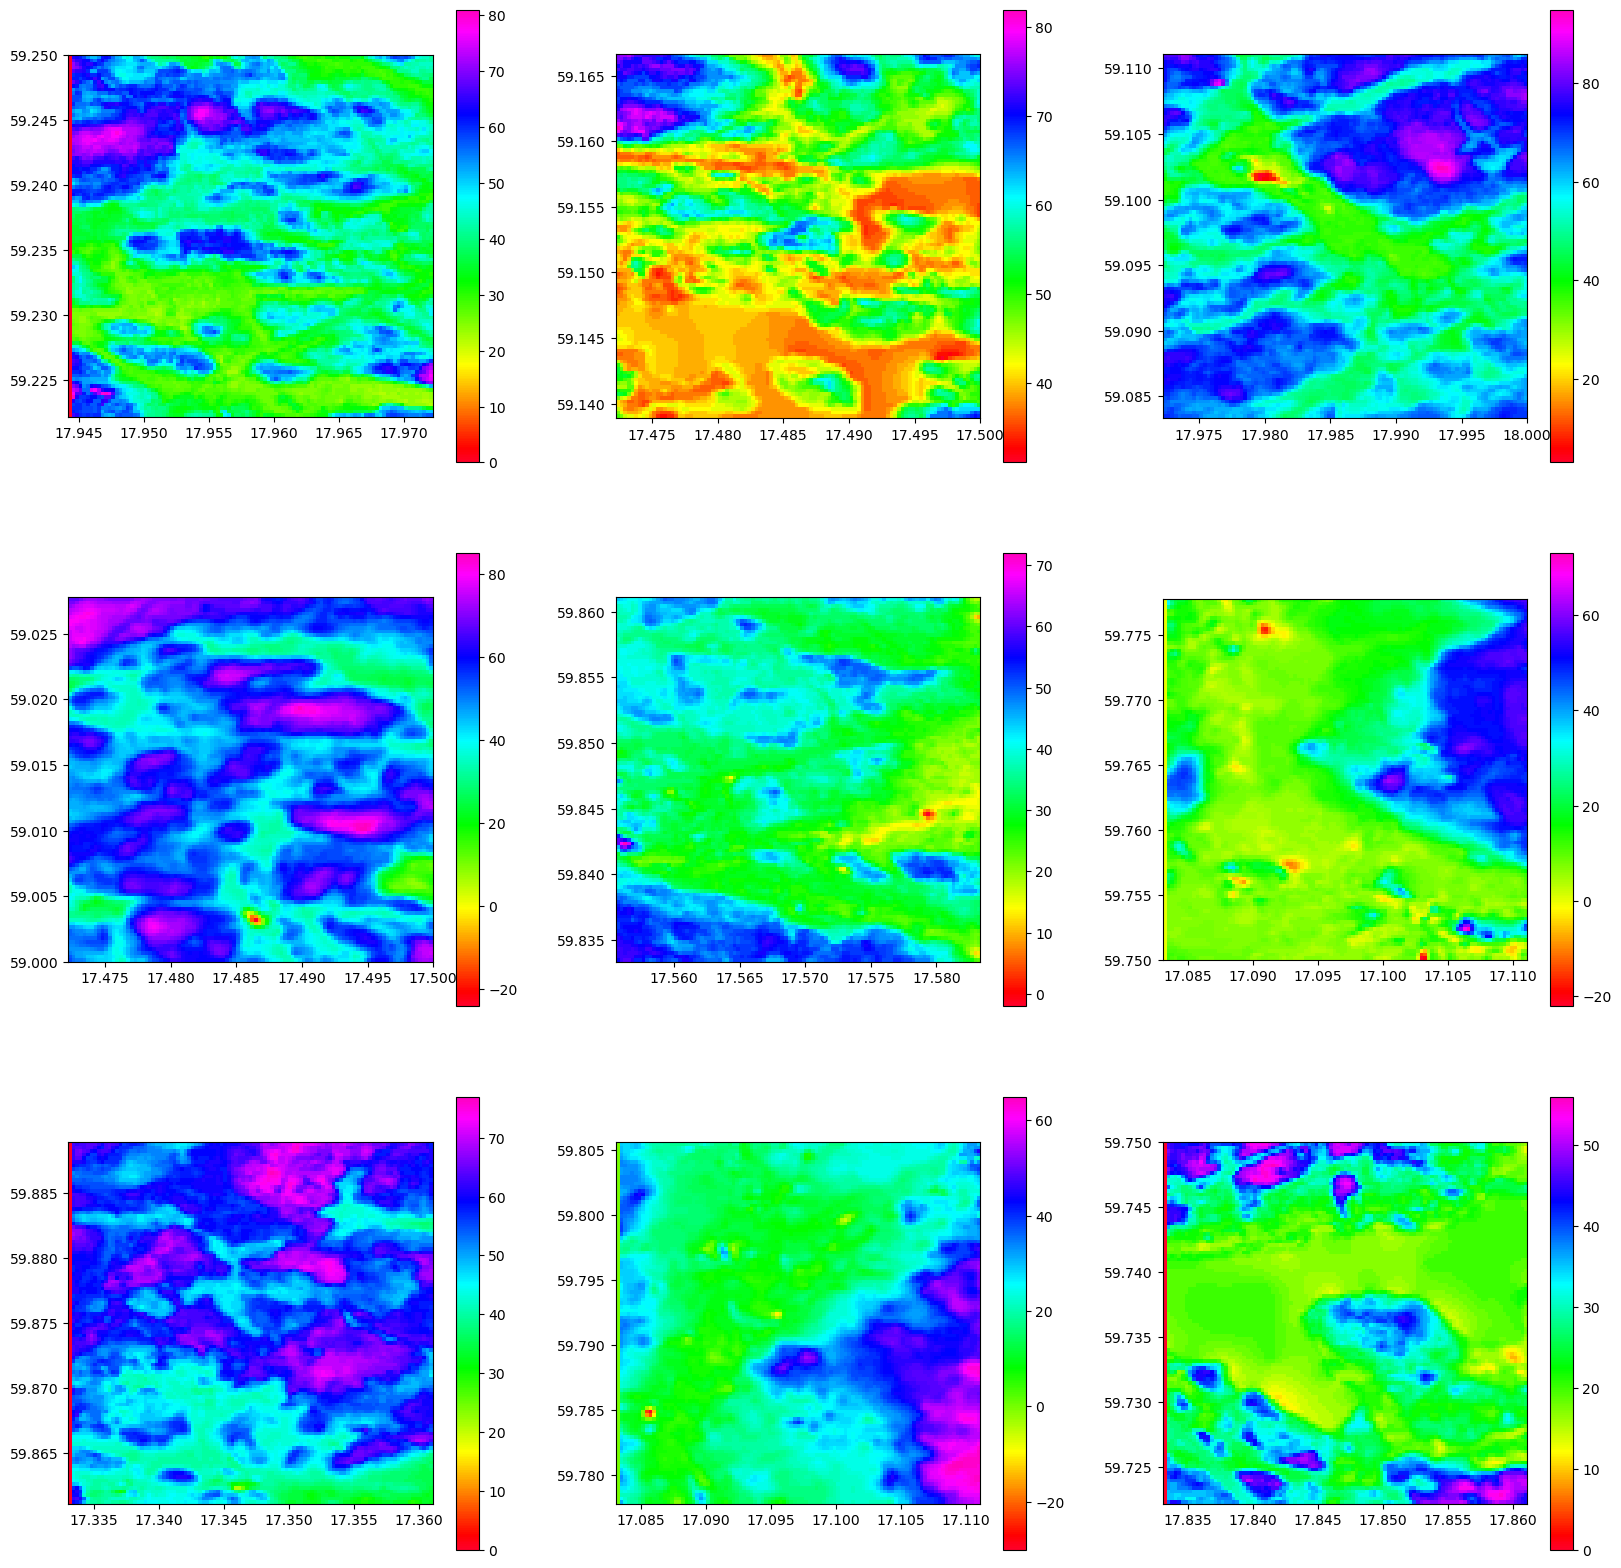

In [27]:
i = 10

dem_test = rasterio.open(dem_folders_paths[i])

fig, axes = plt.subplots(3, 3,figsize=(20,20))


#show(dem_test)
dem_test = rasterio.open(dem_folders_paths[i])
ax = axes[0, 0]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(dem_folders_paths[i+100])
ax = axes[0, 1]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(dem_folders_paths[i+200])
ax = axes[0, 2]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(dem_folders_paths[i+300])
ax = axes[1, 0]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)


dem_test = rasterio.open(dem_folders_paths[i+400])
ax = axes[1, 1]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(dem_folders_paths[i+500])
ax = axes[1, 2]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(dem_folders_paths[i+350])
ax = axes[2, 0]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)


dem_test = rasterio.open(dem_folders_paths[i+460])
ax = axes[2, 1]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(dem_folders_paths[i+570])
ax = axes[2, 2]
retted = rasterio.plot.show(dem_test, ax=ax,cmap='gist_rainbow')#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)


plt.savefig('Images_thesis/aSweden_dem_smalll_all.png',format="png",  bbox_inches='tight',dpi=1000)

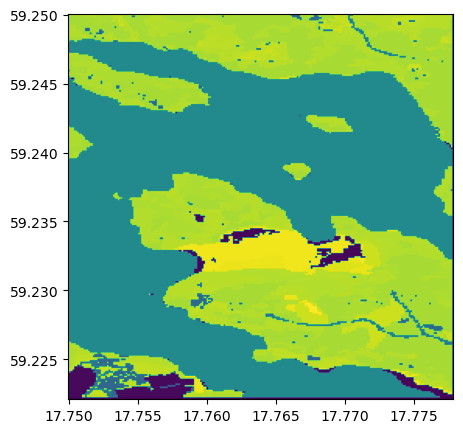

In [15]:
sat_test = rasterio.open(sat_folders_paths[i])
#show(sat_test)

fig, ax = plt.subplots(figsize=(5, 5))
#show(dem_test)
retted = rasterio.plot.show(sat_test, ax=ax)#, cmap='Greys_r')
im = retted.get_images()[0]


In [6]:
sat_folders_paths = sorted(glob.glob('SwedenData/Raw_data/Sat_labels/*'))

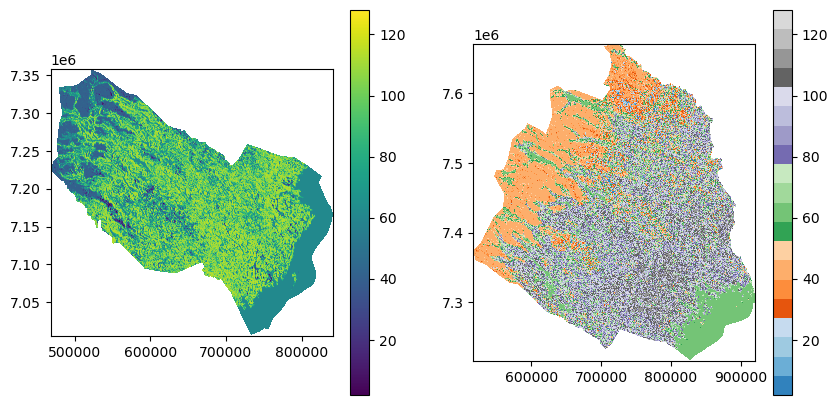

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2,figsize=(10,5))


#show(dem_test)
dem_test = rasterio.open(sat_folders_paths[1])
ax = axes[0]
retted = rasterio.plot.show(dem_test, ax=ax)#, cmap='Greys_r')
im = retted.get_images()[0]
fig.colorbar(im, ax=ax)

dem_test = rasterio.open(sat_folders_paths[2])
ax = axes[1]
retted = rasterio.plot.show(dem_test, ax=ax, cmap = 'tab20c')#, cmap='Greys_r')
im = retted.get_images()[0]
#fig.colorbar(im, ax=ax)